In [1]:
#We import the required libraries for data exploration and visualization.

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
#Next we read the datasets.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


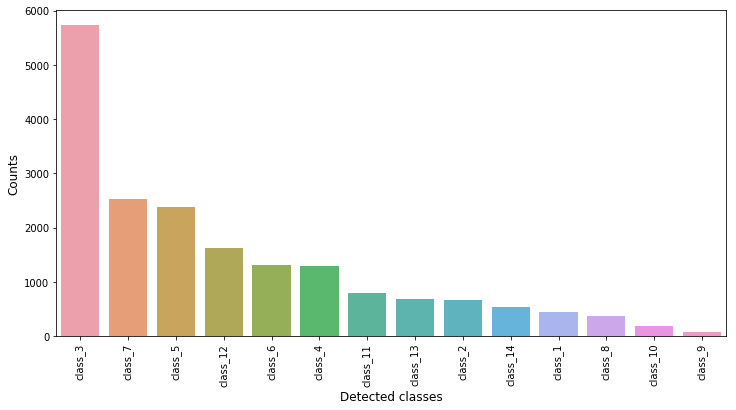

In [3]:
#Distribution of the target variable.

detected_counts = train.detected.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(detected_counts.index, detected_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Detected classes', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

Text(0, 0.5, 'Count')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


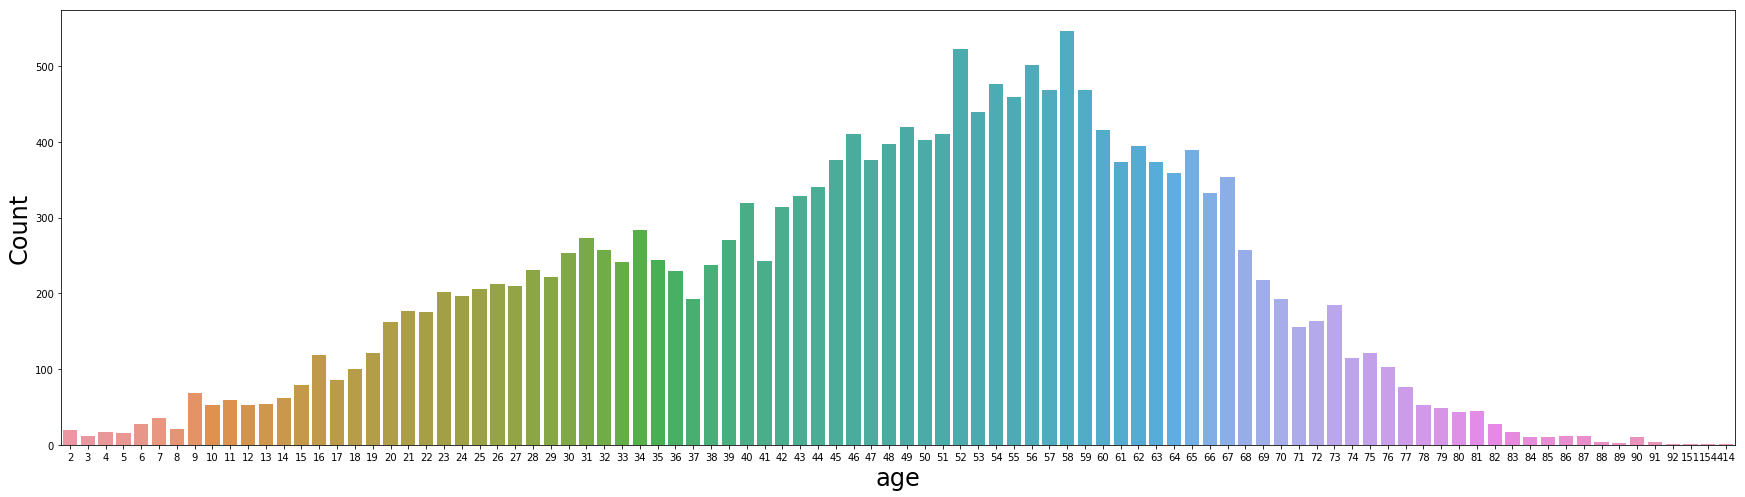

In [4]:
#Distribution of the variable 'age'.

ax = plt.figure(figsize=(30, 8))
sns.countplot(train.age)
axis_font = {'fontname':'Arial', 'size':'24'}
plt.xlabel('age',  **axis_font)
plt.ylabel('Count',  **axis_font)

Text(0, 0.5, 'Median Age')

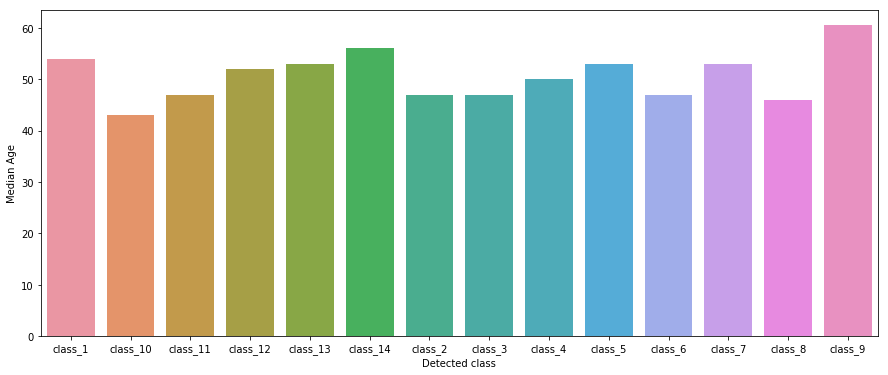

In [5]:
#Distribution of the variable 'age' over the target variable. 

temp = train.groupby(['detected']).median()
ax = plt.figure(figsize=(15, 6))
sns.barplot(temp.index, temp.age)
plt.xlabel('Detected class')
plt.ylabel('Median Age')

In [ ]:
#Load the image data and visualise it USING Open CV.

TRAIN_PATH = 'train_/'
TEST_PATH = 'test_/'

import cv2
img = cv2.imread(TRAIN + 'scan_0000.png')
print(img.shape)
plt.imshow(img)

In [ ]:
#We create a function, which reads an image, resizes it to 128 x128 dimensions and returns it.

def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    return img

from tqdm import tqdm 
train_img = []
for img_path in tqdm(train['image_name'].values):
    train_img.append(read_img(TRAIN_PATH + img_path))

In [ ]:
#Rescaling the images

x_train = np.array(train_img, np.float32) / 255.

In [ ]:
#Mean of the images

mean_img = np.mean(x_train, axis=0)
plt.imshow(mean_img)

In [ ]:
#Standard deviation of the images

std_img = np.std(x_train, axis=0)
plt.imshow(std_img)

In [ ]:
#Normalization

x_train_norm = (x_train - mean_img) / std_img
x_train_norm.shape

In [ ]:
#Encoding the target variable as integers

class_list = train['detected'].tolist()
Y_train = {k:v+1 for v,k in enumerate(set(class_list))}
y_train = [Y_train[k] for k in class_list]

In [ ]:
#One-hot encoding the target variable.

from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [ ]:
#Importing the required libraries

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping

In [ ]:
#We create a Sequential model using 'categorical cross-entropy' as our loss function and 'adam' as the optimizer.

model = Sequential()
model.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (128,128,3)))
#if you resize the image above, change the input shape
model.add(Convolution2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
#We define an early stopping condition for the model. If the val_acc is the same three times, the model stops.

early_stops = EarlyStopping(patience=3, monitor='val_acc')

In [ ]:
#Training the model for 10 epochs.

model.fit(x_train_norm, y_train, batch_size=100, epochs=10, validation_split=0.3, callbacks=[early_stops])

In [ ]:
#Now that we have built and trained our model, it is time to predict the test data.

test_img = []
for img in tqdm(test['image_name'].values):
    test_img.append(read_img(TEST_PATH + img))

#Applying the same data-preprocessing steps on the test data.
x_test = np.array(test_img, np.float32) / 255.
x_test_norm = (test_img, np.float32) / 255.

#The test data is normalised

predictions = model.predict(x_test_norm)
predictions = np.argmax(predictions, axis= 1)

y_maps = dict()
y_maps = {v:k for k, v in Y_train.items()}
pred_labels = [y_maps[k] for k in predictions]

#Creating the submission file.
sub = pd.DataFrame({'row_id':test.row_id, 'detected':pred_labels})
sub.to_csv('submission.csv', index=False)